In [22]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from models import BasicTransformer

## Data Preparation

In [4]:
x = torch.load('X.pt')
y = torch.load('y.pt')

# Create a set of all possible play descriptors
play_descriptors = set()
for s in x.flatten():
    play_descriptors.add(s)
for s in y.flatten():
    play_descriptors.add(s)

# Assign each play descriptor a unique token
play_to_tok = {s: i for i, s in enumerate(play_descriptors)}
num_token_types = len(play_descriptors)

# Convert x and y to their token representations
x_tok = torch.zeros(x.shape, dtype=torch.long)
y_tok = torch.zeros(y.shape, dtype=torch.long)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x_tok[i, j] = play_to_tok[x[i, j]]

for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        y_tok[i, j] = play_to_tok[y[i, j]]



In [18]:
# Split into train and test
train_examples = math.floor(len(x) * 0.8)

# Train on only one example for now
x_train = x_tok[:train_examples][:8000]
y_train = y_tok[:train_examples][:8000]

x_test = x_tok[train_examples:][:2000]
y_test = y_tok[train_examples:][:2000]

In [6]:
def accuracy(preds, labels):
    return sum(preds[:, -1].argmax(dim=1) == labels[:, -1].argmax(dim=1)) / len(preds)

## Training Loop

In [26]:
def train(model, device, n_epochs=5, lr=0.001, batch_size=32, save_path="weights.pt"):
    train_loader = torch.utils.data.DataLoader(
        list(zip(x_train, y_train)),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        list(zip(x_test, y_test)),
        batch_size=batch_size,
        shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        model.train()
        i = 0
        train_loss = 0
        train_acc = 0
        for x_bat, y_bat in iter(train_loader):
            x_bat = x_bat.to(device)
            y_bat = y_bat.to(device)

            x_bat.permute(1, 0)
            y_bat = F.one_hot(y_bat, num_classes=num_token_types).float()
            optimizer.zero_grad()
            y_pred = model(x_bat)
            loss = criterion(y_pred, y_bat)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            i += 1
            train_acc += accuracy(y_pred, y_bat)

            # print(f'Epoch {epoch}, iter {i}, loss: {loss.item()}')

        train_acc = train_acc / len(train_loader)

        model.eval()
        val_loss = 0
        val_acc = 0
        for x_val, y_val in iter(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(x_val)
            y_val = F.one_hot(y_val, num_classes=num_token_types).float()
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()
            val_acc += accuracy(y_pred, y_val)

        val_acc = val_acc / len(val_loader)
        print(f'Epoch {epoch}, iter {i}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}')

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    torch.save(model.state_dict(), save_path)

    return train_losses, train_accs, val_losses, val_accs

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(num_token_types, ninp=128, nhead=128, nhid=2, nlayers=2, dropout=0.2).to(device=device)

train_losses, train_accs, val_losses, val_accs = train(model, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, iter 250, train_loss: 0.36097594554303214, train_acc: 0.23475000262260437, val_loss: 0.09116804460063577, val_acc: 0.3650793731212616
Epoch 1, iter 250, train_loss: 0.08784000790910795, train_acc: 0.40549999475479126, val_loss: 0.08651688270037994, val_acc: 0.337797611951828
Epoch 2, iter 250, train_loss: 0.04767717144568451, train_acc: 0.43299999833106995, val_loss: 0.08965517673641443, val_acc: 0.34375
Epoch 3, iter 250, train_loss: 0.03741890854871599, train_acc: 0.4416249990463257, val_loss: 0.09058821597136557, val_acc: 0.3482142984867096
Epoch 4, iter 250, train_loss: 0.033583216445549624, train_acc: 0.4517500102519989, val_loss: 0.09324884123634547, val_acc: 0.352182537317276


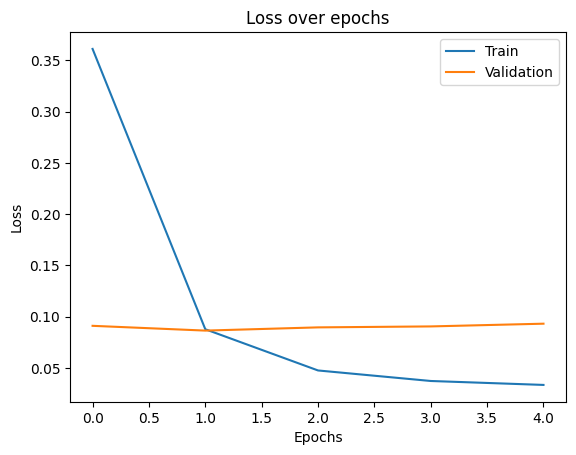

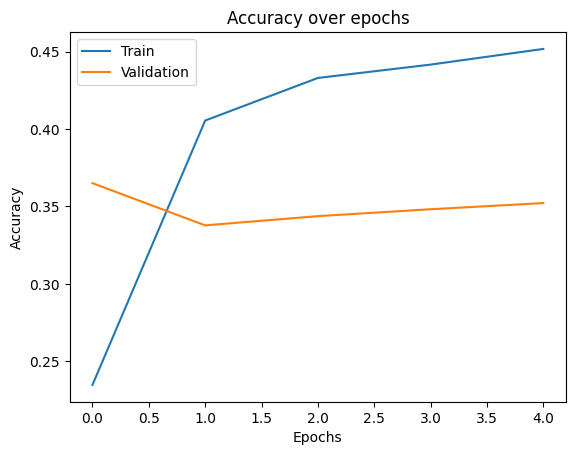

In [28]:
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.savefig("losses.png", bbox_inches="tight")

plt.figure()
plt.plot(train_accs)
plt.plot(val_accs)
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.savefig("accs.png", bbox_inches="tight")